## CUNY MSDA Fall 2017 Semester
### DATA 620
### Project 2:  Movie and User Similarity in the MovieLens Dataset
By Dmitriy Vecheruk

## Introduction and Summary

**Course assignment**

1) Identify a large 2-node network dataset—you can start with a dataset in a repository.  
2) Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.  
3) Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.  
4) What can you infer about each of the distinct groups?

**Summary of the findings**  
  
This analysis is investigating the MovieLens dataset:  
These files contain 1,000,209 anonymous ratings of approximately 3,900 movies made by 6,040 MovieLens users who joined MovieLens in 2000.[1] 

The analysis consists of two parts.   
The first part shows how a bipartite graph of users and their ratings of movies can be used in order to construct a similarity graph of movies. The resulting graph is intuitively understandable, as the degree corresponds to movie popularity among users, and edge weight between movies corresponds to the similarity between two films.   
   
The second part of the analysis is an attempt to identify groups of similar users by projecting the bipartite graph onto user nodes. However, this analysis has failed to discover any well-connected groups using the island method and testing for age and gender as possible predictors of increased similarity between users in terms of movie preferences.
  
Overall, the analysis also highlights the challenges typical to recommender systems - the very high number of possible user-item pairings in a very sparse matrix requiring either a reduction to the most frequently rated items (the approach followed in this analysis), or scaling up of the computation resources. 


## 1. Setup and acquire the data

In [473]:
# Setup: libraries and helper functions
import os,urllib2,zipfile
import networkx as net
import networkx.algorithms.bipartite as bipartite
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [299]:
# Helper functions to fetch, analyze and visualize the data

def download_file(url, file_path):
    """Downloads a file from a given url into the provided local file"""
    
    try:
        url_response = urllib2.urlopen(url)
        with open(file_path, 'w') as f: f.write(url_response.read())
        print "Downloaded into {}".format(file_path)
   
    except URLError as e:
        if hasattr(e, 'reason'):
            print 'We failed to reach a server.'
            print 'Reason: ', e.reason
        elif hasattr(e, 'code'):
            print 'The server couldn\'t fulfill the request.'
            print 'Error code: ', e.code

def unzip_file(zip_file, unzip_folder):
    """Extracts all contents of a zip file to a folder.
    Based on: https://stackoverflow.com/a/3451150/8066374"""
    
    zip_ref = zipfile.ZipFile(zip_file, 'r')
    zip_ref.extractall(unzip_folder)
    zip_ref.close()

def compute_graph_metrics(g):
    """Computes the basic node and edge counts as well as degree centrality measures"""
    node_cnt = g.number_of_nodes()
    edge_cnt = len(g.edges())
    deg = g.degree()
    degrees = sorted([v for (k,v) in deg.iteritems()]) 
    
    return dict(
    node_cnt = node_cnt,
    edge_cnt = edge_cnt,
    avg_degree = sum(degrees)/len(degrees),
    min_degree = degrees[0],
    max_degree = degrees[-1],
    )

def draw_weighted_graph(g,pos,weight_name,with_labels = True,node_size=300):
    """
    Draws a graph with edges colored according to the weight_name edge attribute
    Based on: https://stackoverflow.com/a/16544157/8066374
    """
    edges,colors = zip(*net.get_edge_attributes(g,weight_name).items())

    net.draw(g,pos = pos,edgelist=edges,edge_color=colors,width=1,alpha=.8,
             with_labels = with_labels,font_size=10,font_family='Arial',font_weight='bold',
            node_size=node_size);

def trim_edges(g, weight=1): 
    """
    Trims the edges based on edge weight
    Source: M. Tsvetovat, A. Kouznetsov (2011), Social Network Analysis for Startups 
    """
    g2=net.Graph()
    for f, to, edata in g.edges(data=True): 
        if edata['weight'] > weight:
            g2.add_edge(f,to,edata)
    return g2

def island_method(g, iterations=5):
    weights= [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations 
    
    step=int((mx-mn)/iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

In [6]:
# Download the data
file_url = "http://files.grouplens.org/datasets/movielens/ml-1m.zip"
local_path = "movielens-1m.zip"

if not os.path.isfile(local_path):
    download_file(file_url, local_path)
    unzip_file(local_path,"data/")    


According to the codebook, the dataset consists of three text files with specific tabular formats:
  
* _ratings.dat_ Contains user-to-movie graph with weights on a 5-scale for each rating (UserID::MovieID::Rating::Timestamp)
* _users.dat_ Contains the categorically encoded metadata on the users (UserID::Gender::Age::Occupation::Zip-code)  
* _movies.dat_ Contains movie titles and genres (MovieID::Title::Genres)
  
There is a technical issue where the IDs of users and movies may coincide as both of them start at 1:  
- UserIDs range between 1 and 6040  
- MovieIDs range between 1 and 3952  
  
A simple fix is to add 'u' to user IDs and 'm' to movie IDs to keep each record unique.

In [74]:
# Read and inspect the data

with open("data/ml-1m/ratings.dat") as f:
    inp_ratings = f.readlines()
    inp_ratings = [item.strip().split('::') for item in inp_ratings]
    # Add user and movie id modifiers and drop the timestamps
    inp_ratings = [['u'+item[0], 'm'+item[1], item[2]] for item in inp_ratings]
inp_ratings[:5]

[['u1', 'm1193', '5'],
 ['u1', 'm661', '3'],
 ['u1', 'm914', '3'],
 ['u1', 'm3408', '4'],
 ['u1', 'm2355', '5']]

We can see at the top of the parsed ratings file a list of ratings from user 1 for multiple movies.

## 2. Build the initial graph and inspect it
Now we can build the initial bipartite graph and inspect its properties

In [130]:
B = net.Graph()
B.add_nodes_from([item[0] for item in inp_ratings], bipartite=0, node_type="user") 
B.add_nodes_from([item[1] for item in inp_ratings], bipartite=1, node_type="movie")
B.add_weighted_edges_from([(item[0], item[1], int(item[2])) for item in inp_ratings],weight="weight")

In [97]:
# Test if the graph is bipartite
net.is_bipartite(B)

True

In [106]:
user_nodes, movie_nodes = bipartite.sets(B)

In [150]:
deg = B.degree()
rating_cnts = sorted([v for (k,v) in deg.iteritems() if k.startswith("u") ]) # only user nodes
reviewer_cnts = sorted([v for (k,v) in deg.iteritems() if k.startswith("m") ]) # only movie nodes
weights = [d["weight"] for (u,v,d) in B.edges(data=True)] # rating scores

In [107]:
print """The initial graph contains: {} nodes, out of which: 
    {} are user nodes, 
    {} are movie nodes.
The graph has {} edges in total.
""".format(len(B.nodes()),len(user_nodes),len(movie_nodes),len(B.edges()))

The initial graph contains: 9746 nodes, out of which: 
    6040 are user nodes, 
    3706 are movie nodes.
The graph has 1000209 edges in total.



In [126]:
print """Count of ratings by user: 
    min: {}, max: {}
Count of ratings per movie:
    min: {}, max: {}""".format(rating_cnts[0], rating_cnts[-1],reviewer_cnts[0], reviewer_cnts[-1]) 

Count of ratings by user: 
    min: 20, max: 2314
Count of ratings per movie:
    min: 1, max: 3428


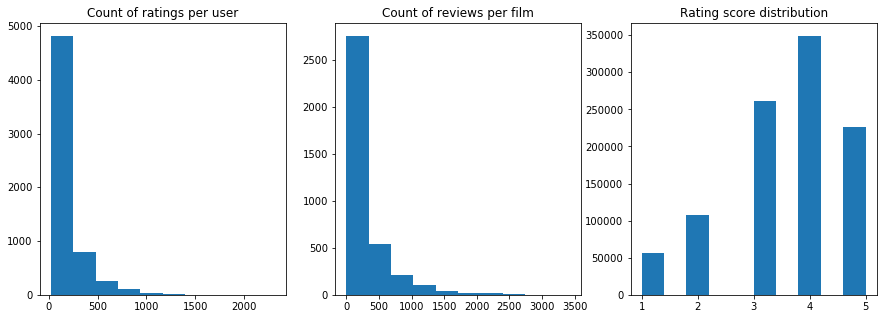

In [380]:
# Plot histograms
f, axarr = plt.subplots(1,3,figsize=(15,5))
axarr[0].hist(rating_cnts);
axarr[0].set_title('Count of ratings per user');
axarr[1].hist(reviewer_cnts);
axarr[1].set_title('Count of reviews per film');
axarr[2].hist(weights);
axarr[2].set_title('Rating score distribution');

Given the large number of edges, and the fact that each user has rated at least 20 films, we will limit the bipartite graph only to the edges with a **rating score of 5** (the highest rating), so as to focus on the movies the users liked. This would enable us to build a clearer picture of association between movies based on user ratings and of users based on shared movie preferences.

In [221]:
high_rating = [(u,v,d) for (u,v,d) in B.edges(data=True) if d["weight"]==5]
B_filtered = net.Graph(high_rating)

In [222]:
user_nodes_filt, movie_nodes_filt = bipartite.sets(B_filtered)

In [223]:
print """The filtered graph contains: {} nodes, out of which: 
    {} are user nodes, 
    {} are movie nodes.
The graph has {} edges in total.
""".format(len(B_filtered.nodes()),len(user_nodes_filt),len(movie_nodes_filt),len(B_filtered.edges()))

The filtered graph contains: 9246 nodes, out of which: 
    6014 are user nodes, 
    3232 are movie nodes.
The graph has 226310 edges in total.



We can see that while the number of users has decreased insignificantly, the number of edges to consider has been reduced to a quarter of the the original value. Now we can proceed to projecting the graphs into the space of movies and users.

### 3. Investigate the affiliation between movies
  
We will project the graph onto movie nodes building an edge between two movies every time a user has provided a positive rating (from our filtered bipartite graph) to both of them. This way, movies that get positive reviews from multiple users should become connected with each other.  
The weight of the edge between two movies will equal the number of users who gave a positive rating to both of the movies. 

In [224]:
M = bipartite.weighted_projected_graph(B_filtered, movie_nodes_filt)

In [225]:
compute_graph_metrics(M)

{'avg_degree': 1047,
 'edge_cnt': 1693544,
 'max_degree': 2890,
 'min_degree': 0,
 'node_cnt': 3232}

As displayed above, the graph of movies has a very large number of edges due to the many combinations of users and movies they have reviewed.  
It would make sense to only focus on the edges (representing movie similarity) that have been validated by at least *n* users.

We can then focus on the largest connected component, and separate it further using the island method described in the course book to identify the most affiliated movies.

In [434]:
# Identify the threshold for the more validated edges

M_weights = [d["weight"] for (u,v,d) in M.edges(data=True)] # weight = number of users who rated both movies


In [ ]:
M_weights = np.array(M_weights)
quantiles = [0,25,50,75,100]
M_weights_pct = dict(zip(quantiles,list(np.percentile(M_weights, quantiles))))
print M_weights_pct

We can see that only 50% of movies have at least two shared users, and 25% have more than five. We will focus the subset with at least five shared positive ratings, as such observations are more valid.

In [277]:
M_trimmed = trim_edges(M, weight=4)

# Reduce the size using the island method
M_cc = list(net.connected_component_subgraphs(M_trimmed))[0] # extract the largest connected component

In [278]:
islands = island_method(M_cc, iterations=8)
for i in islands:
    # print the threshold level, size of the graph, and number of connected components ... 
    print i[0], len(i[1]), len(list(net.connected_component_subgraphs(i[1])))

5 2073 1
143 226 1
281 81 2
419 37 1
557 19 1
695 10 2
833 3 1
971 2 1
1109 2 1


We can see that all the movies seem to be well-connected, and trimming at various levels only provides two separate components at the threshold of 281 leaving 81 nodes in total.
We pick this threshold level to visualize the structure:

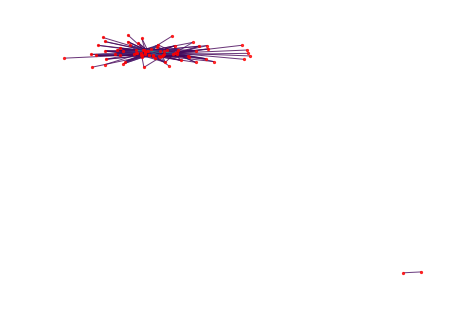

In [429]:
m_result = islands[2][1]
plt.figure(1,figsize=(6,4)) 
pos=net.spring_layout(m_result,weight='weight', scale=30)
draw_weighted_graph(m_result,pos,weight_name="weight",with_labels=False,node_size=5)
plt.show()

In [337]:
# Read the names of the movies
with open("data/ml-1m/movies.dat") as f:
    inp_movies = f.readlines()
    inp_movies = [item.strip().split('::') for item in inp_movies]
    # Add user and movie id modifiers and drop the timestamps
    inp_movies = [['m'+item[0], item[1], item[2]] for item in inp_movies] # adjust the ids
    inp_movies = dict([(item[0],item[1]) for item in inp_movies]) # convert to dict
inp_movies.items()[:5]

[('m3548', 'Auntie Mame (1958)'),
 ('m2488', 'Peeping Tom (1960)'),
 ('m3239', "Isn't She Great? (2000)"),
 ('m1722', 'Tomorrow Never Dies (1997)'),
 ('m1723', 'Twisted (1996)')]

In [338]:
# Add titles to the movies in the result graph
for i in m_result.nodes():
    m_result.node[i]["title"] =  inp_movies[i]

In [339]:
m_result.nodes(data=True)[:5]

[('m296', {'title': 'Pulp Fiction (1994)'}),
 ('m1219', {'title': 'Psycho (1960)'}),
 ('m2396', {'title': 'Shakespeare in Love (1998)'}),
 ('m1089', {'title': 'Reservoir Dogs (1992)'}),
 ('m541', {'title': 'Blade Runner (1982)'})]

In [307]:
net.write_gexf(m_result,"m_result.gexf")

Now we can:   
  
1) visually inspect the relationships between the movies in the resulting graph  
2) get the popularity ranking of the movies in the resulting graph 

First, we'll investigate the two connected components in the graph.

In [342]:
net.write_gexf(m_result,"m_result.gexf")

The island method has returned two components: a small one containing two films, and a large one, containing the rest.
Inspecting the small component we see two animation films about Wallice and Grommit (the third movie from the trilogy was not in the filtered data set), and the large component is dominated by Hollywood blockbusters such as Star Wars, Godfather, and American Beauty. 

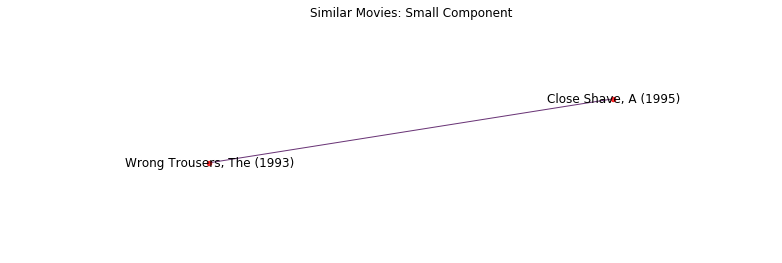

In [391]:

movies_small = list(net.connected_component_subgraphs(m_result))[1]
movies_large = list(net.connected_component_subgraphs(m_result))[0]

# Small component
plt.figure(1,figsize=(10,3)) 
pos = net.spectral_layout(movies_small,scale=0.01)
labs= net.get_node_attributes(movies_small, 'title')
draw_weighted_graph(movies_small,pos,weight_name="weight",with_labels=False,node_size=20)
net.draw_networkx_labels(movies_small,pos = pos, labels=labs);
plt.title("Similar Movies: Small Component")
plt.show()

As is is difficult to layout graphs using Matplotlib, here is a visualization of the large component that has been cleaned up in Gephi:

![](movies_large.png)

We can see that Star Wars, Godfather, Raiders of the Lost Ark, and American Beauty are the films that have the highest degree (seen and rated by most people) and the highest edge weight (rated positively by most users).  
In order to validate this, below is a top-10 list of movies by descending weighted degree centrality:

In [404]:
m_l_deg = movies_large.degree(weight="weight")
m_l_top10 = sorted(m_l_deg.items(), key=lambda x: x[1],reverse=True)[:10]
for item in m_l_top10: print inp_movies[item[0]] 

Star Wars: Episode IV - A New Hope (1977)
American Beauty (1999)
Godfather, The (1972)
Raiders of the Lost Ark (1981)
Star Wars: Episode V - The Empire Strikes Back (1980)
Shawshank Redemption, The (1994)
Matrix, The (1999)
Silence of the Lambs, The (1991)
Schindler's List (1993)
Saving Private Ryan (1998)


In addition, we can get top-10 most co-rated films (which would form best recommendations for popular movies to watch):

In [418]:
m_l_edgewt = net.get_edge_attributes(movies_large,"weight").items()
m_l_top10_edges = sorted(m_l_edgewt, key=lambda x: x[1],reverse=True)[:10]
for item in m_l_top10_edges: 
    print inp_movies[item[0][0]] + " - " + inp_movies[item[0][1]]

Star Wars: Episode V - The Empire Strikes Back (1980) - Star Wars: Episode IV - A New Hope (1977)
Raiders of the Lost Ark (1981) - Star Wars: Episode IV - A New Hope (1977)
Raiders of the Lost Ark (1981) - Star Wars: Episode V - The Empire Strikes Back (1980)
Godfather: Part II, The (1974) - Godfather, The (1972)
Star Wars: Episode IV - A New Hope (1977) - Matrix, The (1999)
Star Wars: Episode IV - A New Hope (1977) - Star Wars: Episode VI - Return of the Jedi (1983)
Star Wars: Episode V - The Empire Strikes Back (1980) - Star Wars: Episode VI - Return of the Jedi (1983)
Star Wars: Episode IV - A New Hope (1977) - Godfather, The (1972)
American Beauty (1999) - Shawshank Redemption, The (1994)
Schindler's List (1993) - Shawshank Redemption, The (1994)


Here we can see that among the most popular movies, the strongest ties appear within movies of the same series and/or genre (e.g. adventure, science fiction with *Star Wars*, *Indiana Jones*, and *The Matrix*, as well as dramatic movies such as *American Beauty*, *Shawshank Redemption*, and *Schindler's List*).  
Surprizingly, *The Godfather* seems to have more in common (in terms of viewer preference) with *Star Wars* than with the popular dramatic movies.


### 4. Investigate the affiliation between users
  
Now we will project our filtered bipartite graph onto user nodes building an edge between two users every time they have rated the same movie positively. This way, users that have similar likes will be tied together.
The weight of the edge between two users will equal the number of movies they both rated positively, thus indicating a strength of the match between individual movie tastes.  
After the user graph is built, we can investigate connected components within it to see if any distinct groups of users can be discerned.

In [430]:
U = bipartite.weighted_projected_graph(B_filtered, user_nodes_filt)

In [432]:
compute_graph_metrics(U)

{'avg_degree': 3873,
 'edge_cnt': 11646972,
 'max_degree': 5964,
 'min_degree': 0,
 'node_cnt': 6014}

As displayed above, the graph of users has a very large number of edges (11 Mln.) due to the many combinations of users and movies they have reviewed (mainly due to the fact that a lot of users have reviewed at least one popular movie).
It would make sense to only focus on the edges (representing user similarity) that have been validated by at least *n* movies in common.  
We can then focus on the largest connected component, and separate it further using the island method described in the course book to identify the most affiliated users.

In [437]:
# Identify the threshold for the more validated edges

U_weights = [d["weight"] for (u,v,d) in U.edges(data=True)] # weight = number of users who rated both movies
U_weights = np.array(U_weights)
quantiles = [0,25,50,75,100]
U_weights_pct = dict(zip(quantiles,list(np.percentile(U_weights, quantiles))))
print U_weights_pct

{0: 1.0, 25: 1.0, 50: 2.0, 75: 5.0, 100: 223.0}


We can see that only 50% of users have at least two shared movies, and 75% five or more. We will focus the subset with at least **ten** shared positively rated movies, as such observations are more valid for judging the similarity in the taste between users.

In [442]:
# Exclude the edges with the weight above the treshold
U_trimmed = trim_edges(U, weight=9)

# Reduce the size using the island method
U_ccs = list(net.connected_component_subgraphs(U_trimmed)) # all connected components
U_cc = U_ccs[0] # extract the largest connected component

In [443]:
# Inspect the connected components
len(U_ccs)

1

In [444]:
compute_graph_metrics(U_trimmed)

{'avg_degree': 482,
 'edge_cnt': 1048500,
 'max_degree': 3807,
 'min_degree': 1,
 'node_cnt': 4347}

We see that after the edge trimming, a single large connected component remains with approx. 1 mln. edges among 4347 users. Now we can try to break it into groups using the island method:

In [445]:
islands1 = island_method(U_cc, iterations=8)
for i in islands1:
    # print the threshold level, size of the graph, and number of connected components ... 
    print i[0], len(i[1]), len(list(net.connected_component_subgraphs(i[1])))

10 4109 1
36 1143 1
62 389 1
88 142 1
114 58 1
140 24 1
166 11 1
192 5 1
218 2 1


We can see that all the users seem to be well-connected, and trimming at various levels only provides a single component at all levels. We will pick the degree level of 36 leaving 1143 users with higher number of jointly rated movies to visualize the structure:

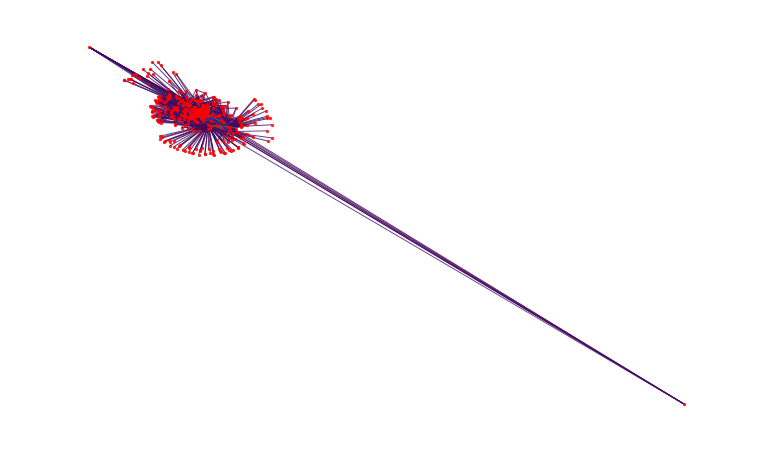

In [460]:
u_result = islands1[2][1]
plt.figure(1,figsize=(10,6)) 
pos=net.spring_layout(u_result, scale=10)
draw_weighted_graph(u_result,pos,weight_name="weight",with_labels=False,node_size=5)
plt.show()

While it is difficult to see the graph details in a Matplotlib visualization, it becomes apparent that the connected component of users has a core and some outer nodes only connected to a few members of the core. These nodes could indicate a different user profile, as their preferences are more specific than that of the core.  
We will investigate this by adding user attributes to the nodes (Gender, Age) and visualizing the edge weight per group of nodes with the same attributes.

In [462]:
# Read the attributes of the users (the schema is UserID::Gender::Age::Occupation::Zip-code)
with open("data/ml-1m/users.dat") as f:
    inp_users = f.readlines()
    inp_users = [item.strip().split('::') for item in inp_users]
    # Add user and movie id modifiers and drop the timestamps
    inp_users = [['u'+item[0], item[1], item[2], item[3]] for item in inp_users] # adjust the ids
    inp_users = dict([(item[0],[item[1],item[2], item[3]]) for item in inp_users]) # convert to dict
inp_users.items()[:5]

[('u1810', ['M', '50', '13']),
 ('u1811', ['M', '56', '2']),
 ('u1812', ['F', '25', '12']),
 ('u1813', ['F', '35', '6']),
 ('u1814', ['M', '50', '7'])]

In [465]:
# Add attributes to the users in the result graph
for i in u_result.nodes():
    u_result.node[i]["Gender"] =  inp_users[i][0]
    u_result.node[i]["Age"] =  inp_users[i][1]
    u_result.node[i]["Occupation"] =  inp_users[i][2]

In [466]:
u_result.nodes(data = True)[:5]

[('u5847',
  {'Age': '18',
   'Attributes': ['F', '18', '4'],
   'Gender': 'F',
   'Occupation': '4'}),
 ('u1812',
  {'Age': '25',
   'Attributes': ['F', '25', '12'],
   'Gender': 'F',
   'Occupation': '12'}),
 ('u5511',
  {'Age': '45',
   'Attributes': ['M', '45', '1'],
   'Gender': 'M',
   'Occupation': '1'}),
 ('u5841',
  {'Age': '35',
   'Attributes': ['F', '35', '7'],
   'Gender': 'F',
   'Occupation': '7'}),
 ('u5517',
  {'Age': '56',
   'Attributes': ['M', '56', '0'],
   'Gender': 'M',
   'Occupation': '0'})]

In [470]:
#net.write_gexf(u_result,"u_result.gexf")
net.write_gml(u_result,"u_result.gml")

According to the codebook, the ages are encoded as follows:
  
*  1:  "Under 18"
* 18:  "18-24"
* 25:  "25-34"
* 35:  "35-44"
* 45:  "45-49"
* 50:  "50-55"
* 56:  "56+"


In [495]:
# Filter to the graphs of younger people (Aged from under 18 to up to 25)
u_younger = [item[0] for item in u_result.nodes(data=True) if ((item[1]['Age'] == '18') | (item[1]['Age'] == '1'))]
u_middle = [item for item in u_result.nodes(data=True) if ((item[1]['Age'] == '25') | (item[1]['Age'] == '35'))]
u_older = [item for item in u_result.nodes(data=True) if ((item not in u_younger) & (item not in u_middle))]

In [510]:
u_younger = u_result.subgraph( [n for n,attrdict in u_result.node.items() if ((attrdict['Age'] == '18') |(attrdict['Age'] == '1'))] )
u_middle = u_result.subgraph( [n for n,attrdict in u_result.node.items() if ((attrdict['Age'] == '25') |(attrdict['Age'] == '35'))] )
u_older = u_result.subgraph( [n for n,attrdict in u_result.node.items() if (attrdict['Age'] not in ['1','18','25','35'])] )

In [544]:
# Extract weight distributions
u_all_wt = [d["weight"] for (u,v,d) in u_result.edges(data=True)]
u_younger_wt = [d["weight"] for (u,v,d) in u_younger.edges(data=True)]
u_middle_wt = [d["weight"] for (u,v,d) in u_middle.edges(data=True)]
u_older_wt = [d["weight"] for (u,v,d) in u_older.edges(data=True)]

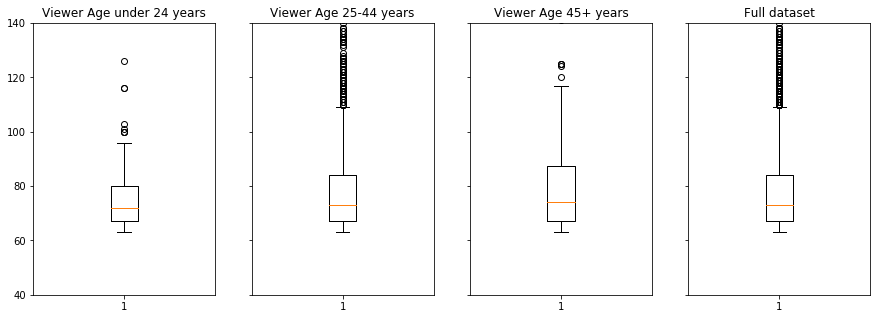

In [545]:
# Compare the edge weight distributions using boxplots

f, axarr = plt.subplots(1,4, sharey=True,figsize=(15,5))
plt.ylim(ymin=40, ymax=140) # limit outliers
axarr[0].boxplot(u_younger_wt,);
axarr[0].set_title('Viewer Age under 24 years');
axarr[1].boxplot(u_middle_wt);
axarr[1].set_title('Viewer Age 25-44 years')
axarr[2].boxplot(u_older_wt);
axarr[2].set_title('Viewer Age 45+ years')
axarr[3].boxplot(u_all_wt);
axarr[3].set_title('Full dataset');

In [548]:
# Print the medians
print "Median edge weights: {}".format([np.median(item) for item in [u_younger_wt, u_middle_wt, u_older_wt,u_all_wt]])

Median edge weights: [72.0, 73.0, 74.0, 73.0]


We can see from the boxplots that while the distributions of the edge weights vary in range across age groups, 
the median values for the edge weight remain the same, indicating that age alone is not a sufficient indicator of a similar taste in films.  
Same tests for gender produced similar results.  
The interpretation of this finding is that popular movies have a broad demographic appeal across ages and genders.

### 5. Outlook
  
Further analyses on the The MovieLens dataset could deepen the inquiry in multiple directions:
  
a) Include somewhat less favorably rated items into the projected movie graph  
b) Use a different heuristic for defining the edge weight between movies or users (e.g. normalizing for the average rating given by each user to the movies in their selection, or excluding the users with extremely high numbers of rated films)  
c) Using more complex measures of graph structure analysis such as modularity to detect connected clusers/communities  
d) Using further node metadata (genre of movies, occupation of users) when analyzing the similarity in the respective unipartite graphs

### Reference
1) F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4, Article 19 (December 2015), 19 pages. DOI=http://dx.doi.org/10.1145/2827872  
2) Tsvetovat, M. & Kouznetsov, A. (2011). Social network analysis for startups : finding connections on the social web. Sebastopol, CA: O'Reilly Media.  
3) [How to use urllib2 in Python](http://www.pythonforbeginners.com/python-on-the-web/how-to-use-urllib2-in-python/)    
4) [HOWTO Fetch Internet Resources Using urllib2](https://docs.python.org/2/howto/urllib2.html)  
5) [Stackoverflow: Unzipping files in Python](https://stackoverflow.com/questions/3451111/unzipping-files-in-python)  
6) [Matplotlib: subplots_demo.py](https://matplotlib.org/examples/pylab_examples/subplots_demo.html)  
7) [Stackoverflow: How to sort a dictionary by value?](https://stackoverflow.com/a/613218/8066374)  
8) [Node / Edge attribute filtering - Google Groups](https://groups.google.com/forum/#!topic/networkx-discuss/mrwIDdlcA3M)